In [3]:
#-*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Import data
data_ETF = pd.read_excel("..\data\ETF.xlsx")
data_ETF.trade_date = pd.to_datetime(data_ETF.trade_date,format="%Y%m%d")
data_option = pd.read_excel("..\data\期权.xlsx")
data_option[data_option.期权代码 == 10004405] # 查看数据示例

,日期,期权代码,期权简称,涨跌幅(%),收盘价,涨停价,跌停价,Delta,Gamma,Vega,Theta,Rho
0,2023-01-03,10004405,50ETF购2023年3月2613A,-4.929577,0.1215,0.3927,0.0001,0.611,1.669,0.470,-0.250,0.320
174,2023-01-04,10004405,50ETF购2023年3月2613A,0.165017,0.1214,0.3863,0.0001,0.631,1.741,0.461,-0.239,0.329
348,2023-01-05,10004405,50ETF购2023年3月2613A,26.732673,0.1536,0.3872,0.0001,0.716,1.560,0.419,-0.229,0.372
522,2023-01-06,10004405,50ETF购2023年3月2613A,9.049479,0.1675,0.4246,0.0001,0.731,1.448,0.408,-0.236,0.375
698,2023-01-09,10004405,50ETF购2023年3月2613A,12.179104,0.1879,0.4400,0.0001,0.761,1.322,0.379,-0.240,0.376
882,2023-01-10,10004405,50ETF购2023年3月2613A,-3.205128,0.1812,0.4622,0.0001,0.749,1.356,0.385,-0.247,0.364
1066,2023-01-11,10004405,50ETF购2023年3月2613A,1.269316,0.1835,0.4554,0.0001,0.762,1.349,0.373,-0.241,0.366
1250,2023-01-12,10004405,50ETF购2023年3月2613A,-0.163310,0.1834,0.4585,0.0001,0.781,1.360,0.353,-0.227,0.372
1434,2023-01-13,10004405,50ETF购2023年3月2613A,18.068367,0.2176,0.4597,0.0001,0.842,1.120,0.291,-0.202,0.398
1618,2023-01-16,10004405,50ETF购2023年3月2613A,18.795620,0.2604,0.4991,0.0001,0.888,0.866,0.229,-0.184,0.404


In [4]:
## 这里定义了一个用于回测的class，其中：
# 1. load_data()
#       输入：将数据加载为成员变量
# 2. get_porfolio()
#       输入：需要做多/空的期权代码，以及回测的开始日期及结束日期
#       输出：1个dict，存放了回测观察期间的ETF及所选取的期权的数据
# 3. cal_return()
#       输入：get_porfolio()输出的 dict
#       输出：1个dataframe，存放了资产组合的组合价值、每期收益率和累计收益率。这里会根据输入期权的类型（看涨/看跌）做空/多相应期权
# 4. plot_result()
#       输入：cal_return()输出的dataframe
#       输出：每期收益率的柱状图，累计收益率的折线图
class BacktestingTool:
    def __init__(self):
        self.data = {}
        
    def load_data(self, data_name, data):
        self.data[data_name] = data

    def get_portfolio(self,option_code, 
                      start_date = 20230103, 
                      end_date = 20230131):
        start_date = pd.to_datetime(start_date, format="%Y%m%d")
        end_date = pd.to_datetime(end_date, format="%Y%m%d")
        tmp1 =  self.data['ETF']; tmp2 =  self.data['option']; tmp2 = tmp2[tmp2.期权代码 == option_code]
        ori_start_date = start_date; ori_end_date = end_date
        
        # 在选取的回测期间， ETF 和期权的数据行数不一定相同，所以最终用于实际回测的时间区间是两者都有数据的时间段
        start_date = max(tmp1['trade_date'].min(), tmp2['日期'].min(), start_date)
        end_date = min(tmp1['trade_date'].max(), tmp2['日期'].max(), end_date)
        
        requiredETF = tmp1[(tmp1['trade_date'] >= start_date) & (tmp1['trade_date'] <= end_date)]
        requiredOption = tmp2[(tmp2['日期'] >= start_date) & (tmp2['日期'] <= end_date)]

        
        portfolio_data = {"ObservationPeriod": (start_date, end_date,ori_start_date,ori_end_date),
                          "ETF": requiredETF,
                          "option": requiredOption
                         }
        return portfolio_data
    
    def cal_return(self, portfolio):
        flag = -1 ## 取值为-1时，表示 short call；取值为1时，表示 long put
        if "沽" in list(portfolio['option']['期权简称'])[0]:
            flag = 1
#         print(flag)
        tmp1 = portfolio["ETF"]; tmp2 = portfolio["option"]; tmp3= portfolio["ObservationPeriod"]
        # print(tmp1['close'])
        # long ETF, long put 的第t期的资产组合价值 = Delta_t * S_t + P_t
        # long ETF, short call 的第t期的资产组合价值 = Delta_t * S_t - C_t
        portfolio_val = pd.Series(np.array(tmp1['close']) * np.array(abs(tmp2['Delta'])*1e4)
                                  + (flag)*np.array(tmp2['收盘价'])) 
#         print(portfolio_val)
        pct_chg = portfolio_val.pct_change(); pct_chg.fillna(value=0, inplace=True) # 每一期的收益率
        total_return = np.cumsum(pct_chg) # 累计收益率
        idx1,idx2 = self.get_max_drawdown(total_return) # 计算最大回撤所用数据的索引
        portfolio_returns = pd.DataFrame({'日期': np.array(tmp2['日期']),
                                          '资产组合价值': portfolio_val, 
                                          '每期收益率': pct_chg, 
                                          '累计收益率': total_return
                                         })
        # 输出回测信息
        position_type = "空" if flag == -1 else "多"
        opt_type = "购" if flag == -1 else "沽"
        option_code = list(tmp2['期权代码'])[0]
        ss,ee = (tmp3[0],tmp3[1])
        oss,oee = (tmp3[2],tmp3[3])

        print("------------------------------------------------------------------")
        print("在本次回测中：")
        print("    [[第 t 期的资产组合]] 1 张代码为【{1}】的认【{2}】期权【{0}】头,Δ_t 张 ETF 多头".format(position_type, option_code,opt_type))
        if (ss != oss) or (ee != oee):
            print("    [[实际回测观察期]] 从 {} 至 {} （而非给定的回测区间 {} 至 {}）".format(ss,ee,oss,oee))
        
        else:
            print("    [[回测观察期]] 从 {} 至 {}".format(ss,ee))
        print("    [[P&L]] 回测期间的最大回撤为：{:.2f}%".format((total_return[idx1]-total_return[idx2])*1e2))

        print("------------------------------------------------------------------")
        return portfolio_returns
        
            
    def plot_result(self, portfolio_returns):
        plt.rcParams['font.sans-serif'] = ['Songti SC']
        periods = portfolio_returns['日期'].apply(lambda x: x.strftime('%Y-%m-%d'))
#         periods = list(range(len(portfolio_returns['日期'])))
#         print(periods)
        total_ret = portfolio_returns['累计收益率'];  
        each_ret = portfolio_returns['每期收益率']
        fig, ax = plt.subplots(1, 1, figsize=(6, 4))
        sns.set_theme(style="whitegrid")
        sns.barplot(x=periods, y=each_ret, color="grey",width=0.5,label='Daily Return')
        sns.lineplot(x=periods, y=total_ret, marker='o',label='Total Return')
        idx1,idx2 = self.get_max_drawdown(total_ret) # 计算最大回撤所用数据的索引
        plt.axvline(x=periods[idx1],linewidth=0.25,linestyle="dashed",color="red")
        plt.axvline(x=periods[idx2],linewidth=0.25,linestyle="dashed",color="red")
#         plt.axvline(x=periods[idx2],linewidth=0.25)
#         ax.vlines([periods[idx1],periods[idx2]],-0.2,0.2,linestyles="dashed",color="red")
        plt.xticks([i for i in periods[::6]], rotation=35,fontsize=7)
        plt.title('Total Return')
        plt.xlabel("Period",fontsize=10)
        plt.ylabel("Return Rate",fontsize=10) 
        plt.legend(fontsize=10)
        
    def get_max_drawdown(self, array):
        array=array[1:] # 将第一个原本是NaN、现在被0填充的收益率排除
#         print(array)
        array = pd.Series(array); cumsum = array.cummax()
        tmp =  list(cumsum-array); max_val =  max(tmp)
#         print(max_val)
        idx_small = tmp.index(max_val)
        val_big=cumsum[idx_small]
        idx_big=list(array).index(val_big)
#         print(array)
        # print(idx_big, idx_small)
        return idx_big+1, idx_small+1

C:\Users\young\AppData\Local\Temp\ipykernel_29572\1953122679.py:54: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pct_chg = portfolio_val.pct_change(); pct_chg.fillna(value=0, inplace=True) # 每一期的收益率
C:\Users\young\miniconda3\envs\opt-pricing\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\young\miniconda3\envs\opt-pricing\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


------------------------------------------------------------------
在本次回测中：
    [[第 t 期的资产组合]] 1 张代码为【10004745】的认【购】期权【空】头,Δ_t 张 ETF 多头
    [[实际回测观察期]] 从 2023-01-07 00:00:00 至 2023-03-22 00:00:00 （而非给定的回测区间 2023-01-07 00:00:00 至 2023-03-31 00:00:00）
    [[P&L]] 回测期间的最大回撤为：8.76%
------------------------------------------------------------------


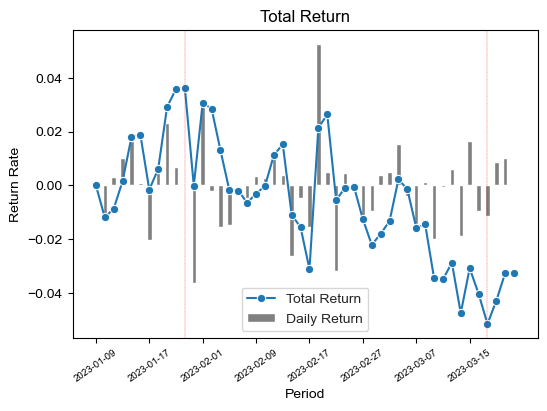

In [5]:
#### 主程序！
## 配置
OPTION_CODE = 10004745
START_DATE = 20230107
END_DATE = 20230331

demo = BacktestingTool()
demo.load_data('ETF', data_ETF); demo.load_data('option', data_option)

demo_portfolio = demo.get_portfolio(OPTION_CODE,START_DATE,END_DATE)
demo_returns = demo.cal_return(demo_portfolio)
demo.plot_result(demo_returns)